2025-07-10 08:29:45.435573: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 08:29:45.790642: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 08:29:51.516649: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 08:29:53.876839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752136197.612267    2074 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752136198.65

Epoch 1/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5311 - loss: 0.5786 - val_accuracy: 0.5930 - val_loss: 0.5394
Epoch 2/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5306 - loss: 0.5327 - val_accuracy: 0.6163 - val_loss: 0.5091
Epoch 3/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5204 - loss: 0.5099 - val_accuracy: 0.6105 - val_loss: 0.4981
Epoch 4/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5675 - loss: 0.4984 - val_accuracy: 0.6105 - val_loss: 0.4652
Epoch 5/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4990 - loss: 0.4577 - val_accuracy: 0.6047 - val_loss: 0.4255
Epoch 6/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5821 - loss: 0.4188 - val_accuracy: 0.5291 - val_loss: 0.3964
Epoch 7/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5671 - loss: 0.3892 - val_accuracy: 0.6453 - val_loss: 0.3733
Epoch 8/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5299 - loss: 0.3722 - val_accuracy: 0.6047 - v

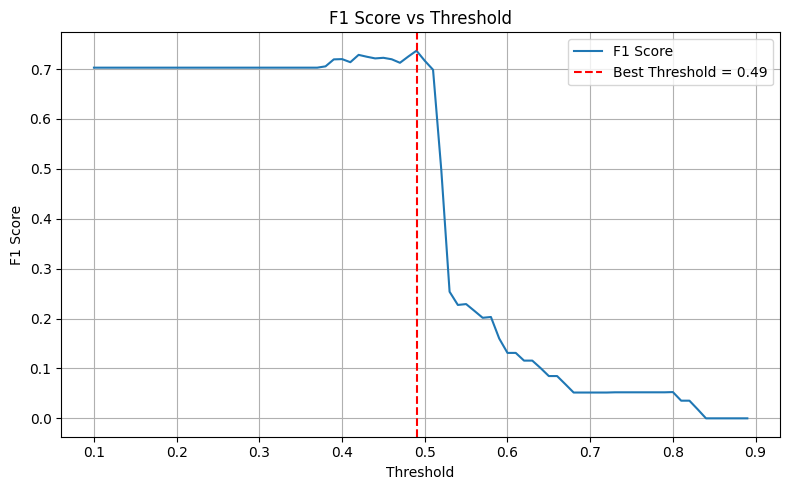

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, precision_score, recall_score
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks, losses, backend as K

# Load dataset
df = pd.read_csv("2_final_deforestation_ml_dataset.csv")
df[['25', '4']] = df[['25', '4']].fillna(0)
df["prev_count_x_33"] = df["prev_count"] * df["33"]  # Interaction feature

# Features and target
features = ['3', '6', '11', '15', '24', '33', '12', '25', '4', 'prev_count', 'prev_count_x_33']
X = df[features]
y = df['target_increase']

# Train/val/test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# Focal loss definition
class FocalLoss(losses.Loss):
    def __init__(self, gamma=2., alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(self.alpha * K.pow(1. - pt, self.gamma) * K.log(pt))

model = keras.Sequential([
    layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    layers.LayerNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.4),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    layers.LayerNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=FocalLoss(),
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(patience=15, restore_best_weights=True)

model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=120,
    batch_size=16,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# Predict
y_prob = model.predict(X_test_s).flatten()
thresholds = np.arange(0.1, 0.9, 0.01)
f1s = [f1_score(y_test, y_prob > t) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
y_pred = (y_prob > best_t).astype(int)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Report
print("Best Threshold:", round(best_t, 3))
print("Accuracy:", round(acc, 3))
print("F1 Score:", round(f1, 3))
print("ROC-AUC:", round(roc, 3))
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred, digits=3))
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_t, color='red', linestyle='--', label=f'Best Threshold = {best_t:.2f}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()